In [ ]:
from datasets import load_dataset,load_from_disk

dataset = load_from_disk("rajpurkar/squad_v2")

import random

random.seed(2022119)

shuffled_indices = random.sample(range(len(dataset['train'])), 15000)

train_data = dataset['train'].select(shuffled_indices)

val_data = dataset['validation']

from transformers import AutoTokenizer, AutoModelForQuestionAnswering , Trainer
import torch 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModelForQuestionAnswering.from_pretrained("SpanBERT/spanbert-base-cased")
tokenizer = AutoTokenizer.from_pretrained("SpanBERT/spanbert-base-cased")

def mark_start_end(of_map, token_type, ans_start, ans_end):
    context_first = None
    for j, ttype in enumerate(token_type):
        if ttype == 1:  # context
            context_first = j
            break

    context_last = None
    if context_first is not None:
        for j in range(context_first, len(token_type)):
            if token_type[j] != 1:  # question or pad
                context_last = j
                break
        if context_last is None:
            context_last = len(token_type)

    if context_first is None or context_last is None:
        return 0, 0

    start_idx = 0
    found_start = False
    for k in range(context_first, context_last):
        tkn_start, tkn_end = of_map[k]
        if tkn_start <= ans_start < tkn_end:
            start_idx = k
            found_start = True
            break

    end_idx = 0
    found_end = False
    for k in range(context_first, context_last):
        tkn_start, tkn_end = of_map[k]
        if tkn_start < ans_end <= tkn_end:
            end_idx = k
            found_end = True
            break

    if not found_start or not found_end:
        return 0, 0

    return start_idx, end_idx


def preprocess_qa_batched(examples):
    tokenized = tokenizer(
        examples["question"],
        examples["context"],
        max_length=384,
        stride=128,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
        truncation="only_second",
    )

    sample_mapping = tokenized.pop("overflow_to_sample_mapping") 
    offset_mapping = tokenized["offset_mapping"] 
    tokenized['example_id'] = sample_mapping
    start_positions = []
    end_positions = []

    for i, offsets in enumerate(offset_mapping):
        sample_idx = sample_mapping[i]

        if len(examples["answers"][sample_idx]["answer_start"]) == 0:
            start_positions.append(0)
            end_positions.append(0)
            continue

        ans_start_char = examples["answers"][sample_idx]["answer_start"][0]
        ans_text = examples["answers"][sample_idx]["text"][0]
        ans_end_char = ans_start_char + len(ans_text)

        q_a_mapping = tokenized.sequence_ids(i)

        sidx, eidx = mark_start_end(
            of_map=offsets,
            token_type=q_a_mapping,
            ans_start=ans_start_char,
            ans_end=ans_end_char
        )
        start_positions.append(sidx)
        end_positions.append(eidx)

    tokenized["start_positions"] = start_positions
    tokenized["end_positions"] = end_positions

    return tokenized


train = train_data.map(
    preprocess_qa_batched,
    batched=True,
    remove_columns=train_data.column_names,
)


def preprocess_qa_batched2(examples):
    tokenized = tokenizer(
        examples["question"],
        examples["context"],
        max_length=384,
        stride=128,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
        truncation="only_second",
    )

    sample_mapping = tokenized.pop("overflow_to_sample_mapping") 
    offset_mapping = tokenized["offset_mapping"]  
    
    tokenized['example_id'] = sample_mapping
    start_positions = []
    end_positions = []

    for i, offsets in enumerate(offset_mapping):
        sample_idx = sample_mapping[i]
        temp_starts = [] ; temp_ends = []
        if len(examples["answers"][sample_idx]["answer_start"]) == 0:
            temp_starts.append(0)
            temp_ends.append(0)
            while(len(temp_starts) < 6):
                temp_starts.append(-1)
                temp_ends.append(-1)
            start_positions.append(temp_starts)
            end_positions.append(temp_ends)    
            continue

        num_answers = len(examples["answers"][sample_idx]["answer_start"])
        
        
        
        for j in range(num_answers):
            
            ans_start_char = examples["answers"][sample_idx]["answer_start"][j]
            ans_text = examples["answers"][sample_idx]["text"][j]
            ans_end_char = ans_start_char + len(ans_text)
    
            q_a_mapping = tokenized.sequence_ids(i)
    
            sidx, eidx = mark_start_end(
                of_map=offsets,
                token_type=q_a_mapping,
                ans_start=ans_start_char,
                ans_end=ans_end_char
            )
            
            temp_starts.append(sidx)
            temp_ends.append(eidx)
    
        start_positions.append(temp_starts)
        end_positions.append(temp_ends)
        while(len(temp_starts) < 6):
            temp_starts.append(-1)
            temp_ends.append(-1)
    tokenized["start_positions"] = start_positions
    tokenized["end_positions"] = end_positions

    return tokenized

val = val_data.map(
    preprocess_qa_batched2,
    batched=True,
    remove_columns=val_data.column_names,
)



Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at SpanBERT/spanbert-base-cased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/15000 [00:00<?, ? examples/s]

Map:   0%|          | 0/11873 [00:00<?, ? examples/s]

In [ ]:
def get(start_logits,end_logits):
    ts = [(start_logits[i], i) for i in range(len(start_logits))]
    te = [(end_logits[i], i) for i in range(len(end_logits))]
    
    ts = sorted(ts, reverse=True)[:min(len(start_logits), 20)]
    te = sorted(te, reverse=True)[:min(len(end_logits), 20)]
    
    mx = -float('inf')
    start_idx = -1
    end_idx = -1
    
    for st, i in ts:
        for ed, j in te:
            if i > j:  
                continue
            if st + ed > mx:
                mx = st + ed
                start_idx = i
                end_idx = j
    return start_idx,end_idx

In [ ]:

import torch
from torch.utils.data import Dataset , DataLoader

class CustomDataset(Dataset):
    def __init__(self, data):  
        self.data = data

    def __len__(self):  
        return len(self.data)

    def convert_to_tensor(self, sample):
        new_sample = {}
        for k, v in sample.items():
            new_sample[k] = torch.tensor(v, dtype=torch.long)
        return new_sample

    def __getitem__(self, idx): 
        sample = self.data[idx]
        tensor_sample = self.convert_to_tensor(sample)
        return tensor_sample

        
train_ds = CustomDataset(train)

val_ds = CustomDataset(val)

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)

val_loader = DataLoader(val_ds, batch_size=8, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

from transformers import BertForQuestionAnswering, AdamW
from tqdm import tqdm 
import numpy as np


def exact_match_score(predictions, references):
    assert len(predictions) == len(references), "Lists must have the same length"
    matches = sum(p == r for p, r in zip(predictions, references))
    return matches / len(references) * 100  


optim = AdamW(model.parameters(),lr=3e-5)
best_em = 0  
best_model_path = "best_model.pth"  

for epoch in range(3) :

    model.train()
    tl = 0
    m = len(train_loader)
    
    for idx , sample in enumerate(tqdm(train_loader)):

        ids = sample['input_ids'].to(device).squeeze(1)
        attn_mask = sample['attention_mask'].to(device).squeeze(1) 
        ttis = sample['token_type_ids'].to(device).squeeze(1) 
        st_posn = sample['start_positions'].to(device) 
        end_posn = sample['end_positions'].to(device)

        optim.zero_grad()

        ops = model(input_ids=ids,
                attention_mask=attn_mask,
                token_type_ids=ttis,
                start_positions=st_posn,
                end_positions=end_posn
            )

        loss = ops.loss 

        loss.backward()

        optim.step()

        tl += loss.item() 

    tl = tl / (m)

    print(f"Epoch {epoch} : loss : {tl}")

    batch_predictions = [] ; batch_references = [] ; example_to_feature = {}

    model.eval()
    
    vl = 0

    exid_2_fidx = {}

    gt = 0 
    
    with torch.no_grad():

        for sample in val_loader :
            
            ids = sample['input_ids'].to(device).squeeze(1)
            attn_mask = sample['attention_mask'].to(device).squeeze(1) 
            ttis = sample['token_type_ids'].to(device).squeeze(1) 
            st_posn = sample['start_positions'].to(device) 
            end_posn = sample['end_positions'].to(device)
            st1 = torch.tensor([i[0] for i in sample['start_positions']]).to(device)
            ed1 = torch.tensor([i[0] for i in sample['end_positions']]).to(device)
            ex_ids = sample['example_id'].to(device)
            
            ops2 = model(
                input_ids=ids,
                attention_mask=attn_mask,
                token_type_ids=ttis,
                start_positions=st1,
                end_positions=ed1
            )
            
            start_logits = ops2.start_logits
            
            end_logits = ops2.end_logits
            
            num_samples = len(start_logits)
    
            vl += ops2.loss.item()
            
            for i in range(num_samples):

                ex_id = sample['example_id'][i]

                if ex_id not in exid_2_fidx : 
                    
                    exid_2_fidx[ex_id] = []
                    
                exid_2_fidx[ex_id].append(gt)

                gt += 1
                
                start_idx,end_idx=get(start_logits[i].tolist(),end_logits[i].tolist())

                if (start_idx == 0 and end_idx == 0) or start_idx > end_idx:
                    
                    pred_answer = "" 
                    
                else:
    
                     idx = ex_ids[i]

                     s2 = sample["offset_mapping"][i][start_idx][0]
                     e2 = sample["offset_mapping"][i][end_idx][1]                    
                     pred_answer = val_data['context'][ex_id][s2 : e2]

                maxi = -1

                best_ref = ""

                for j in range(len(st_posn[i])):

                    if st_posn[i][j] == -1:
                        
                        break

                    if st_posn[i][j] == 0 and end_posn[i][j] == 0 : 
    
                        ref_answer = ""
                        
                    else:
                        
                         s3 = sample["offset_mapping"][i][st_posn[i][j]][0]
                         e3 = sample["offset_mapping"][i][end_posn[i][j]][1]
                         ref_answer = val_data['context'][ex_id][s3 : e3]
                     
                    if exact_match_score([pred_answer], [ref_answer]) > maxi:
                        maxi = exact_match_score([pred_answer], [ref_answer])
                        best_ref = ref_answer
                    
                batch_predictions.append(pred_answer) ; batch_references.append(best_ref)

        
        final_preds = [] ; final_refs = []
        
        for exid in list(exid_2_fidx.keys()) :
            
            fids = exid_2_fidx[exid] ; max_em = -1
            
            for fidx in fids : 
                
                pred = batch_predictions[fidx] ; ref = batch_references[fidx] 
                best_pred = "" ; best_ref = ""
                temp_em = exact_match_score([pred] , [ref])
                if temp_em > max_em : 
                    best_pred = pred ; best_ref = ref ; max_em = temp_em 
            final_preds.append(best_pred) ; final_refs.append(best_ref)

        em = exact_match_score(final_preds , final_refs)
        print(final_preds[:10])
        if em > best_em:
            best_em = em
            torch.save(model.state_dict(), best_model_path)
            print(f"New best model saved with EM: {best_em:.2f}%")


    # print(batch_predictions[:10]) ; print(batch_references[:10])
    # preds, refs = get_predictions(model, tokenizer, val_preprocessed, val_data)
    # em_score = exact_match_score(preds, refs)
    # print(f"Exact Match Score: {em_score:.2f}%")

    # first task is to extract the predictions ->
    
    
    print("-"*30)
    print(f"Epoch {epoch} : loss : {vl / m} em : {em}")
    print("-"*30)

/home/dcll/anaconda3/envs/pytorch-cuda11.1/lib/python3.8/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
100%|██████████| 1913/1913 [06:28<00:00,  4.93it/s]


Epoch 0 : loss : 2.233038886672716
['France', '10th and 11th centuries', 'Denmark, Iceland and Norway', 'Rollo', '10th century', '', 'Normandy', '', '', 'William the Conqueror']
New best model saved with EM: 70.08%
------------------------------
Epoch 0 : loss : 1.3448067369164438 em : 70.07643519271426
------------------------------


100%|██████████| 1913/1913 [06:26<00:00,  4.95it/s]


Epoch 1 : loss : 1.4105819322585562
['France', '10th and 11th centuries', '', 'Rollo', '10th century', '', 'Normandy', 'raiders and pirates from Denmark, Iceland and Norway who, under their leader Rollo', 'The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France. They were descended from Norse ("Norman" comes from "Norseman") raiders and pirates from Denmark, Iceland and Norway who, under their leader Rollo, agreed to swear fealty to King Charles III of West Francia. Through generations of assimilation and mixing with the native Frankish and Roman-Gaulish populations, their descendants would gradually merge with the Carolingian-based cultures of West Francia. The distinct cultural and ethnic identity of the Normans emerged initially in the first half of the 10th century', 'William the Conqueror']
------------------------------
Epoch 1 : loss : 1.418562600469938 em : 68.043584322

100%|██████████| 1913/1913 [06:27<00:00,  4.94it/s]


Epoch 2 : loss : 1.0686331785323417
['France', '10th and 11th centuries', 'Denmark, Iceland and Norway', 'Rollo', '10th', '', '', '', '', 'William the Conqueror']
New best model saved with EM: 71.78%
------------------------------
Epoch 2 : loss : 1.440145671694801 em : 71.7840299235648
------------------------------


In [ ]:
for epoch in range(3) :

    model.train()
    tl = 0
    m = len(train_loader)
    
    for idx , sample in enumerate(tqdm(train_loader)):

        ids = sample['input_ids'].to(device).squeeze(1)
        attn_mask = sample['attention_mask'].to(device).squeeze(1) 
        ttis = sample['token_type_ids'].to(device).squeeze(1) 
        st_posn = sample['start_positions'].to(device) 
        end_posn = sample['end_positions'].to(device)

        optim.zero_grad()

        ops = model(input_ids=ids,
                attention_mask=attn_mask,
                token_type_ids=ttis,
                start_positions=st_posn,
                end_positions=end_posn
            )

        loss = ops.loss 

        loss.backward()

        optim.step()

        tl += loss.item() 

    tl = tl / (m)

    print(f"Epoch {epoch} : loss : {tl}")

    batch_predictions = [] ; batch_references = [] ; example_to_feature = {}

    model.eval()
    
    vl = 0

    exid_2_fidx = {}

    gt = 0 
    
    with torch.no_grad():

        for sample in val_loader :
            
            ids = sample['input_ids'].to(device).squeeze(1)
            attn_mask = sample['attention_mask'].to(device).squeeze(1) 
            ttis = sample['token_type_ids'].to(device).squeeze(1) 
            st_posn = sample['start_positions'].to(device) 
            end_posn = sample['end_positions'].to(device)
            st1 = torch.tensor([i[0] for i in sample['start_positions']]).to(device)
            ed1 = torch.tensor([i[0] for i in sample['end_positions']]).to(device)
            ex_ids = sample['example_id'].to(device)
            
            ops2 = model(
                input_ids=ids,
                attention_mask=attn_mask,
                token_type_ids=ttis,
                start_positions=st1,
                end_positions=ed1
            )
            
            start_logits = ops2.start_logits
            
            end_logits = ops2.end_logits
            
            num_samples = len(start_logits)
    
            # print(sample.keys())

            vl += ops2.loss.item()
            
            for i in range(num_samples):

                ex_id = sample['example_id'][i]

                if ex_id not in exid_2_fidx : 
                    
                    exid_2_fidx[ex_id] = []
                    
                exid_2_fidx[ex_id].append(gt)

                gt += 1
                
                # start_idx = torch.argmax(start_logits[i]).item()
                
                # end_idx = torch.argmax(end_logits[i]).item()

                start_idx,end_idx=get(start_logits[i].tolist(),end_logits[i].tolist())

                if (start_idx == 0 and end_idx == 0) or start_idx > end_idx:
                    
                    pred_answer = "" 
                    
                else:
    
                     idx = ex_ids[i]

                     s2 = sample["offset_mapping"][i][start_idx][0]
                     e2 = sample["offset_mapping"][i][end_idx][1]                    
                     pred_answer = val_data['context'][ex_id][s2 : e2]

                maxi = -1

                best_ref = ""

                for j in range(len(st_posn[i])):

                    if st_posn[i][j] == -1:
                        
                        break

                    if st_posn[i][j] == 0 and end_posn[i][j] == 0 : 
    
                        ref_answer = ""
                        
                    else:
                        
                         s3 = sample["offset_mapping"][i][st_posn[i][j]][0]
                         e3 = sample["offset_mapping"][i][end_posn[i][j]][1]
                         ref_answer = val_data['context'][ex_id][s3 : e3]
                     
                    if exact_match_score([pred_answer], [ref_answer]) > maxi:
                        maxi = exact_match_score([pred_answer], [ref_answer])
                        best_ref = ref_answer
                    
                batch_predictions.append(pred_answer) ; batch_references.append(best_ref)

        
        final_preds = [] ; final_refs = []
        
        for exid in list(exid_2_fidx.keys()) :
            
            fids = exid_2_fidx[exid] ; max_em = -1
            
            for fidx in fids : 
                
                pred = batch_predictions[fidx] ; ref = batch_references[fidx] 
                best_pred = "" ; best_ref = ""
                temp_em = exact_match_score([pred] , [ref])
                if temp_em > max_em : 
                    best_pred = pred ; best_ref = ref ; max_em = temp_em 
            final_preds.append(best_pred) ; final_refs.append(best_ref)

        em = exact_match_score(final_preds , final_refs)
        print(final_preds[:10])
        if em > best_em:
            best_em = em
            torch.save(model.state_dict(), best_model_path)
            print(f"New best model saved with EM: {best_em:.2f}%")


    # print(batch_predictions[:10]) ; print(batch_references[:10])
    # preds, refs = get_predictions(model, tokenizer, val_preprocessed, val_data)
    # em_score = exact_match_score(preds, refs)
    # print(f"Exact Match Score: {em_score:.2f}%")

    # first task is to extract the predictions ->
    
    
    print("-"*30)
    print(f"Epoch {epoch} : loss : {vl / m} em : {em}")
    print("-"*30)

100%|██████████| 1913/1913 [08:24<00:00,  3.79it/s]


Epoch 0 : loss : 0.8409553096048881
['France', '10th and 11th centuries', 'The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France. They were descended from Norse ("Norman" comes from "Norseman") raiders and pirates from Denmark, Iceland and Norway', 'Rollo', '10th century', '', '', '', '', 'William the Conqueror']
New best model saved with EM: 73.80%
------------------------------
Epoch 0 : loss : 1.5450213973863673 em : 73.80061798666449
------------------------------


100%|██████████| 1913/1913 [08:17<00:00,  3.85it/s]


Epoch 1 : loss : 0.7116515048284432
['France', '10th and 11th centuries', '', 'Rollo', '10th', '', 'Normandy', '', '', 'William the Conqueror']
New best model saved with EM: 74.88%
------------------------------
Epoch 1 : loss : 1.6112814961898034 em : 74.88209464953651
------------------------------


100%|██████████| 1913/1913 [06:27<00:00,  4.94it/s]


Epoch 2 : loss : 0.626298661568186
['France', '10th and 11th centuries', 'Denmark, Iceland and Norway', 'Rollo', '10th', '', 'Normandy', '', '', 'William the Conqueror']
------------------------------
Epoch 2 : loss : 1.8745409746484425 em : 74.35355342332086
------------------------------


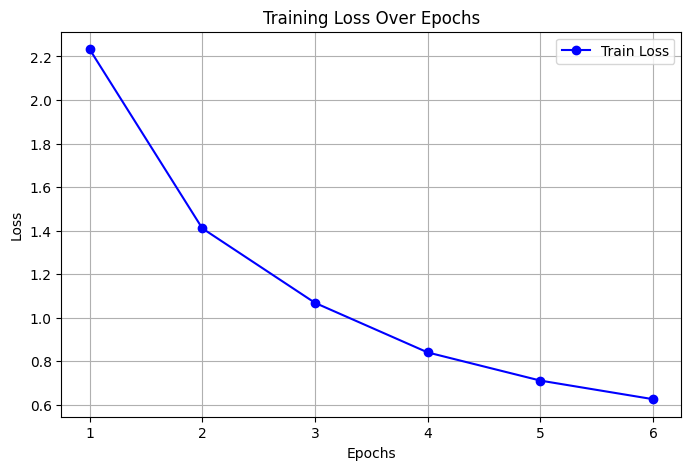

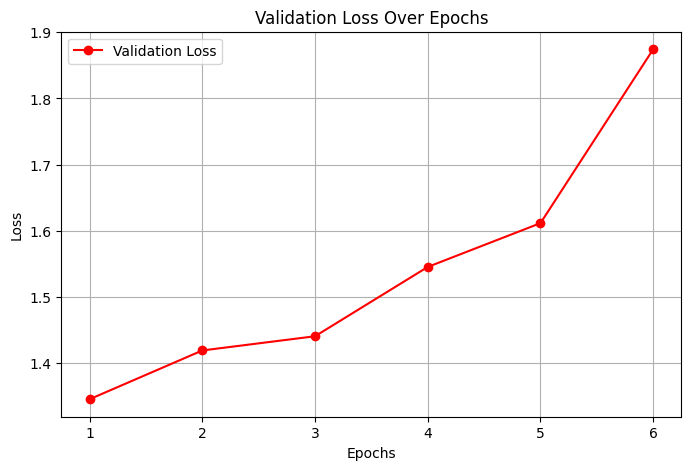

In [ ]:
import matplotlib.pyplot as plt

# note we have used the outputs from above cells only 

epochs = list(range(1, 7))  

train_loss = [2.2330, 1.4106, 1.0686, 0.8410, 0.7117, 0.6263]
val_loss = [1.3448, 1.4186, 1.4401, 1.5450, 1.6113, 1.8745]

plt.figure(figsize=(8, 5))
plt.plot(epochs, train_loss, marker='o', linestyle='-', color='b', label='Train Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(epochs, val_loss, marker='o', linestyle='-', color='r', label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Validation Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.show()
